In [1]:
# Importar bibliotecas
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import (
    HillClimbSearch, BicScore, K2Score, MaximumLikelihoodEstimator, BayesianEstimator
)
from pgmpy.inference import VariableElimination
import numpy as np


c:\Users\crish\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Carregar o dataset Titanic
# Se estiver usando o Google Colab, você pode carregar o arquivo 'train.csv' diretamente
# Aqui, vamos usar um link direto para o dataset
url = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'

# Carregar o dataset
data = pd.read_csv(url)


In [3]:
# Verificar as primeiras linhas do dataset
print("Primeiras linhas do dataset:")
print(data.head())

# Verificar valores ausentes
print("\nValores ausentes por coluna:")
print(data.isnull().sum())

# Preencher valores ausentes em 'Age' com a mediana
data['Age'].fillna(data['Age'].median(), inplace=True)

# Preencher valores ausentes em 'Embarked' com o valor mais frequente
data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)

# Excluir a coluna 'Cabin' devido ao grande número de valores ausentes
data.drop(columns=['Cabin'], inplace=True)

# Converter 'Sex' para valores numéricos
data['Sex'] = data['Sex'].map({'male': 0, 'female': 1})

# Converter 'Embarked' para valores numéricos
data['Embarked'] = data['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

# Selecionar as colunas relevantes
data = data[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]

# Discretizar 'Age' e 'Fare'
from sklearn.preprocessing import KBinsDiscretizer

# Configurar o discretizador para criar 5 faixas com base na frequência (quantile)
age_discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')

# Ajustar e transformar a coluna 'Age'
data['Age'] = age_discretizer.fit_transform(data[['Age']]).astype(int)

# Verificar os dados após a discretização
print("\nDados após a discretização de 'Age' com KBinsDiscretizer:")
print(data.head())






data['Fare'] = pd.qcut(data['Fare'], 4, labels=[0, 1, 2, 3])

# Converter todas as colunas para inteiro
data = data.astype(int)

# Verificar os dados após o pré-processamento
print("\nDados após o pré-processamento:")
print(data.head())


Primeiras linhas do dataset:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450

c:\Users\crish\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [4]:
print("\nEstatísticas descritivas do dataset:\n")
print(data.describe())



Estatísticas descritivas do dataset:

         Survived      Pclass         Sex         Age       SibSp       Parch  \
count  891.000000  891.000000  891.000000  891.000000  891.000000  891.000000   
mean     0.383838    2.308642    0.352413    1.648709    0.523008    0.381594   
std      0.486592    0.836071    0.477990    1.009531    1.102743    0.806057   
min      0.000000    1.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    2.000000    0.000000    1.000000    0.000000    0.000000   
50%      0.000000    3.000000    0.000000    2.000000    0.000000    0.000000   
75%      1.000000    3.000000    1.000000    2.000000    1.000000    0.000000   
max      1.000000    3.000000    1.000000    3.000000    8.000000    6.000000   

             Fare    Embarked  
count  891.000000  891.000000  
mean     1.497194    0.361392  
std      1.118156    0.635673  
min      0.000000    0.000000  
25%      0.500000    0.000000  
50%      1.000000    0.000000  
75%    

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


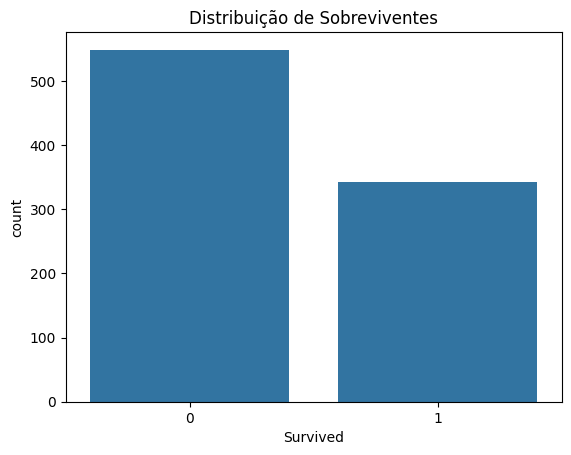

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


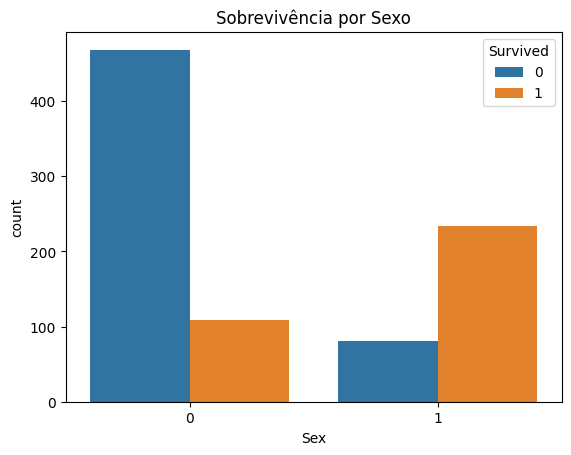

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


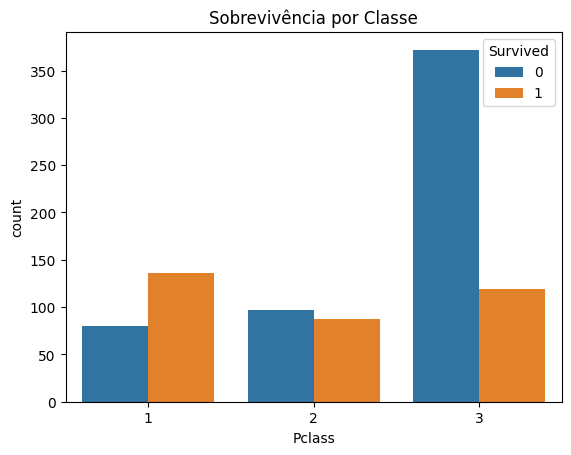

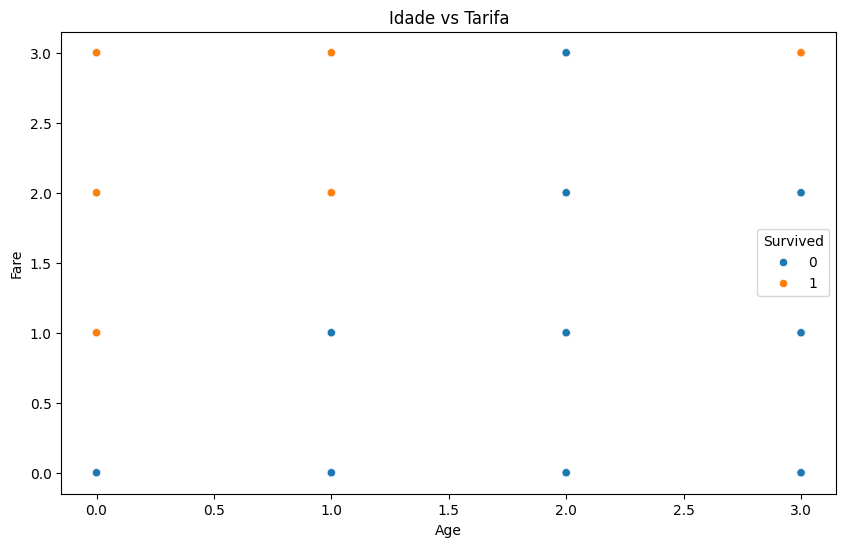

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


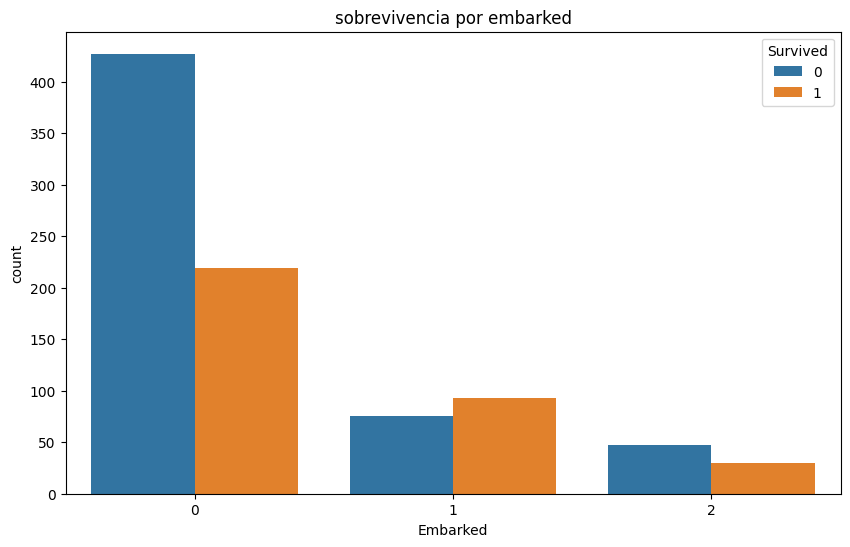

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


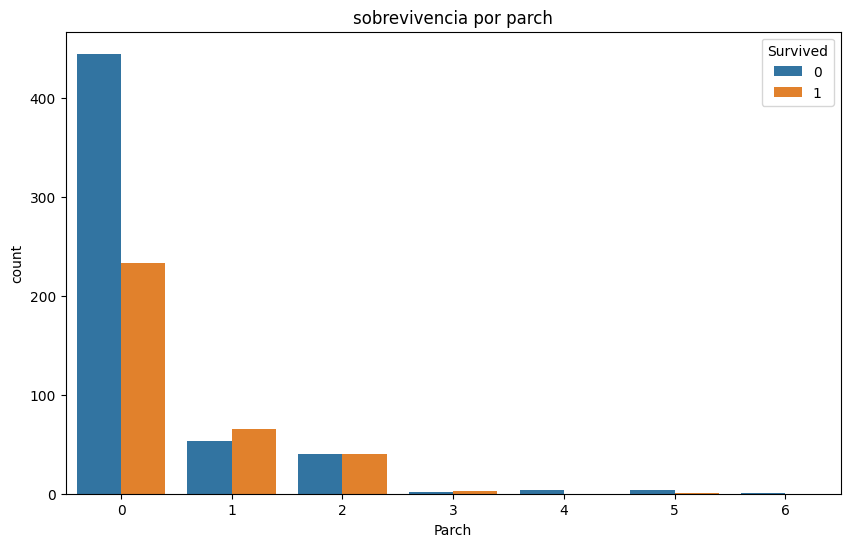

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


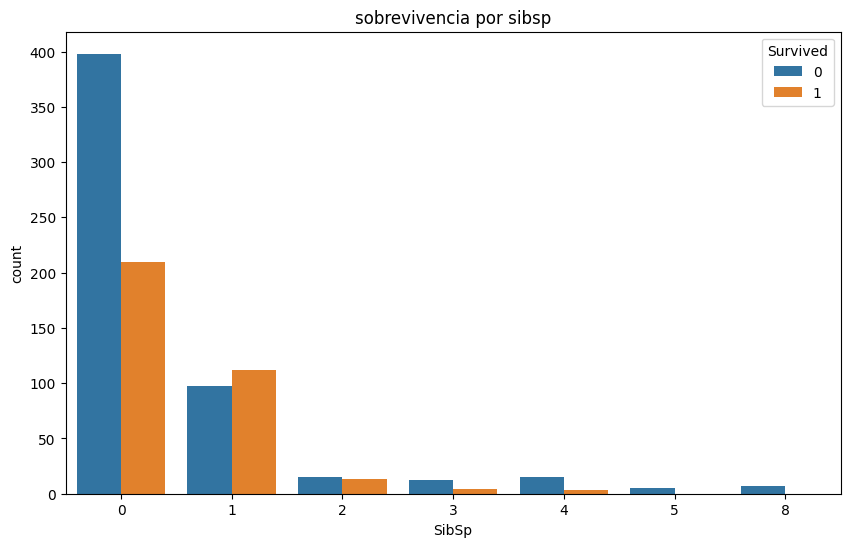

In [5]:
# Gráfico de contagem de sobreviventes
sns.countplot(x='Survived', data=data)
plt.title('Distribuição de Sobreviventes')
plt.show()

# Gráfico de sobrevivência por sexo
sns.countplot(x='Sex', hue='Survived', data=data)
plt.title('Sobrevivência por Sexo')
plt.show()

# Gráfico de sobrevivência por classe
sns.countplot(x='Pclass', hue='Survived', data=data)
plt.title('Sobrevivência por Classe')
plt.show()

# Gráfico de dispersão para 'Age' vs 'Fare'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Age', y='Fare', hue='Survived', data=data)
plt.title('Idade vs Tarifa')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='Embarked', hue='Survived', data=data)
plt.title('sobrevivencia por embarked')
plt.show()


plt.figure(figsize=(10, 6))
sns.countplot(x='Parch', hue='Survived', data=data)
plt.title('sobrevivencia por parch')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='SibSp', hue='Survived', data=data)
plt.title('sobrevivencia por sibsp')
plt.show()


In [6]:
from sklearn.feature_selection import mutual_info_classif

# Definir as variáveis independentes e a variável alvo
X = data.drop('Survived', axis=1)
y = data['Survived']

# Calcular a mutual information
mi = mutual_info_classif(X, y, discrete_features=True)

# Exibir a importância das variáveis
importance = pd.Series(mi, index=X.columns)
importance.sort_values(ascending=False, inplace=True)
print("Importância das variáveis (Mutual Information):")
print(importance)


Importância das variáveis (Mutual Information):
Sex         0.150870
Pclass      0.058107
Fare        0.046180
SibSp       0.023197
Parch       0.016366
Embarked    0.014233
Age         0.004641
dtype: float64


In [7]:
# Separar a variável alvo (Survived) das variáveis preditoras
X = data.drop('Survived', axis=1)
y = data['Survived']

# Dividir os dados em treinamento e teste
train_data, test_data = train_test_split(
    data, test_size=0.2, random_state=42, stratify=data['Survived']
)
 
print(f"\nConjunto de Treinamento: {len(train_data)} registros")
print(f"Conjunto de Teste: {len(test_data)} registros")


Conjunto de Treinamento: 712 registros
Conjunto de Teste: 179 registros


In [8]:
# Usando Hill Climbing e BIC Score
est_hc = HillClimbSearch(train_data)
best_model_bic = est_hc.estimate(scoring_method=BicScore(train_data))

# Usando Hill Climbing e K2 Score
k2score = K2Score(train_data)
best_model_k2 = est_hc.estimate(scoring_method=k2score)

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 27/1000000 [00:00<3:40:20, 75.64it/s]


In [9]:
# Modelo com BIC Score
model_bic = BayesianNetwork(best_model_bic.edges())
model_bic.fit(train_data, estimator=BayesianEstimator, prior_type='BDeu')

# Modelo com K2 Score
model_k2 = BayesianNetwork(best_model_k2.edges())
model_k2.fit(train_data, estimator=BayesianEstimator, prior_type='BDeu')

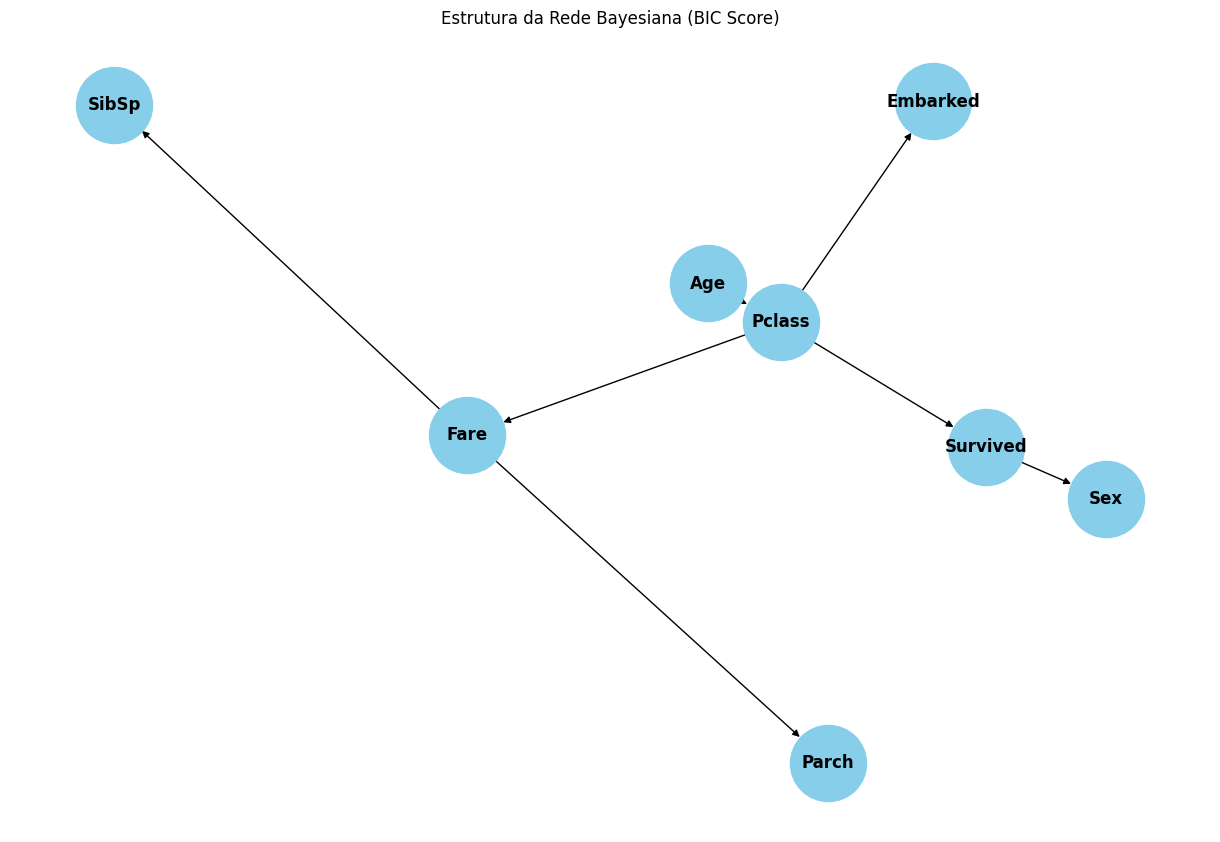

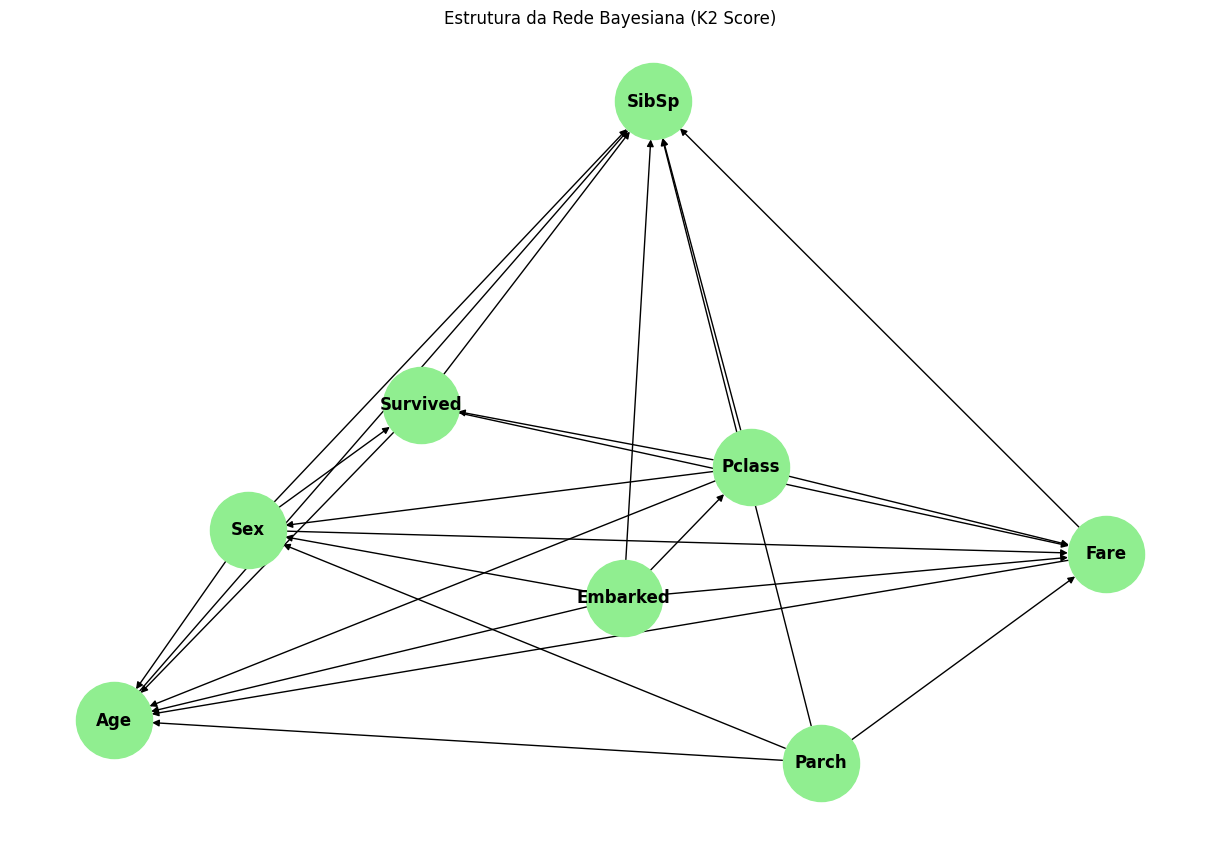

In [10]:
# Estrutura com BIC Score
plt.figure(figsize=(12, 8))
G_bic = nx.DiGraph(model_bic.edges())
pos_bic = nx.spring_layout(G_bic, seed=42)
nx.draw(G_bic, pos_bic, with_labels=True, node_size=3000, node_color="skyblue",
        font_size=12, font_weight="bold", arrows=True)
plt.title("Estrutura da Rede Bayesiana (BIC Score)")
plt.show()

# Estrutura com K2 Score
plt.figure(figsize=(12, 8))
G_k2 = nx.DiGraph(model_k2.edges())
pos_k2 = nx.spring_layout(G_k2, seed=42)
nx.draw(G_k2, pos_k2, with_labels=True, node_size=3000, node_color="lightgreen",
        font_size=12, font_weight="bold", arrows=True)
plt.title("Estrutura da Rede Bayesiana (K2 Score)")
plt.show()

In [11]:
def predict(model, data, evidence_vars, target_var='Survived'):
    inference = VariableElimination(model)
    predictions = []
    for idx, row in data.iterrows():
        evidence = {var: row[var] for var in evidence_vars}
        try:
            query_result = inference.query(variables=[target_var], evidence=evidence)
            prob = query_result.values
            predicted_state = np.argmax(prob)
            predictions.append(int(predicted_state))
        except Exception as e:
            #print(f'Erro no índice {idx}: {e}')
            predictions.append(0)  # Valor padrão em caso de erro
    return predictions

# Definir as variáveis de evidência
evidence_vars = data.columns.tolist()
evidence_vars.remove('Survived')

# Avaliar o modelo BIC
predictions_bic = predict(model_bic, test_data, evidence_vars)
accuracy_bic = accuracy_score(test_data['Survived'], predictions_bic)
print(f"\nAcurácia do Modelo BIC no Conjunto de Teste: {accuracy_bic:.4f}")

# Avaliar o modelo K2
predictions_k2 = predict(model_k2, test_data, evidence_vars)
accuracy_k2 = accuracy_score(test_data['Survived'], predictions_k2)
print(f"\nAcurácia do Modelo K2 no Conjunto de Teste: {accuracy_k2:.4f}")



Acurácia do Modelo BIC no Conjunto de Teste: 0.7765

Acurácia do Modelo K2 no Conjunto de Teste: 0.7095


In [12]:
print("=== Discussão dos Resultados ===\n")

print(f"A acurácia do Modelo BIC é {accuracy_bic:.2f}")
print(f"A acurácia do Modelo K2 é {accuracy_k2:.2f}")




=== Discussão dos Resultados ===

A acurácia do Modelo BIC é 0.78
A acurácia do Modelo K2 é 0.71


In [13]:
import numpy as np
import pandas as pd
from pgmpy.inference import VariableElimination
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split

# Função de predição com probabilidade
def predict(model, data, evidence_vars, target_var='Survived'):
    """
    Realiza predições utilizando o modelo fornecido.

    Args:
        model: Modelo treinado (BIC ou K2).
        data (pd.DataFrame): Dados para predição.
        evidence_vars (list): Lista de variáveis de evidência.
        target_var (str): Variável alvo (padrão 'Survived').

    Returns:
        predictions (list): Lista de classes previstas.
        probabilities (list): Lista de probabilidades da classe positiva.
    """
    inference = VariableElimination(model)
    predictions = []
    probabilities = []
    for idx, row in data.iterrows():
        evidence = {var: row[var] for var in evidence_vars}
        try:
            query_result = inference.query(variables=[target_var], evidence=evidence)
            prob = query_result.values
            predicted_state = np.argmax(prob)
            predictions.append(int(predicted_state))
            # Assumindo que a classe positiva é '1'
            probabilities.append(prob[1] if len(prob) > 1 else prob[0])
        except Exception as e:
            print(f"Erro na linha {idx}: {e}")
            predictions.append(0)
            probabilities.append(0.0)
    return predictions, probabilities

# Definir as variáveis de evidência
evidence_vars = test_data.columns.tolist()
if 'Survived' not in evidence_vars:
    print("A variável 'Survived' não está presente no test_data.")
else:
    evidence_vars.remove('Survived')  # Remover a variável alvo

# Verificar se todas as variáveis de evidência estão presentes no modelo
model_vars = model_bic.nodes()
missing_vars_model = [var for var in evidence_vars if var not in model_vars]
if missing_vars_model:
    print(f"As seguintes variáveis de evidência não estão presentes no modelo BIC: {missing_vars_model}")

# Avaliar o modelo BIC
predictions_bic, probabilities_bic = predict(model_bic, test_data, evidence_vars)
logloss_bic = log_loss(test_data['Survived'], probabilities_bic)
# Verificar se há pelo menos duas classes para calcular o AUC
if len(test_data['Survived'].unique()) > 1:
    auc_bic = roc_auc_score(test_data['Survived'], probabilities_bic)
else:
    auc_bic = float('nan')  # Não é possível calcular o AUC com uma única classe

print(f"\n=== Avaliação do Modelo BIC ===")
print(f"Entropia Cruzada (Log Loss): {logloss_bic:.4f}")
print(f"AUC-ROC: {auc_bic:.4f}")

# Avaliar o modelo K2
predictions_k2, probabilities_k2 = predict(model_k2, test_data, evidence_vars)
logloss_k2 = log_loss(test_data['Survived'], probabilities_k2)
# Verificar se há pelo menos duas classes para calcular o AUC
if len(test_data['Survived'].unique()) > 1:
    auc_k2 = roc_auc_score(test_data['Survived'], probabilities_k2)
else:
    auc_k2 = float('nan')  # Não é possível calcular o AUC com uma única classe

print(f"\n=== Avaliação do Modelo K2 ===")
print(f"Entropia Cruzada (Log Loss): {logloss_k2:.4f}")
print(f"AUC-ROC: {auc_k2:.4f}")



=== Avaliação do Modelo BIC ===
Entropia Cruzada (Log Loss): 0.4824
AUC-ROC: 0.8217

=== Avaliação do Modelo K2 ===
Entropia Cruzada (Log Loss): 0.9197
AUC-ROC: 0.7397


In [14]:
# Discussão dos resultados
print("\n=== Discussão dos Resultados ===\n")

print(f"A Entropia Cruzada (Log Loss) do Modelo BIC é {logloss_bic:.4f}")
print(f"O AUC-ROC do Modelo BIC é {auc_bic:.4f}")
print(f"A Entropia Cruzada (Log Loss) do Modelo K2 é {logloss_k2:.4f}")
print(f"O AUC-ROC do Modelo K2 é {auc_k2:.4f}")

print("""
Analisando as métricas de Entropia Cruzada e AUC-ROC, podemos observar:

- **Entropia Cruzada (Log Loss)**: Avalia a confiança das previsões, penalizando erros de forma mais intensa.
- **AUC-ROC**: Mede a capacidade do modelo de distinguir entre as classes, útil para dados desbalanceados.

Comparando os dois modelos, a análise das métricas indica possíveis áreas de melhoria, como:

- **Incluir mais variáveis**: Considerar outras características presentes no dataset.
- **Ajustar a discretização**: Experimentar diferentes formas de discretizar variáveis contínuas.
- **Experimentar outros algoritmos**: Como o PC Algorithm ou métodos híbridos.
""")


=== Discussão dos Resultados ===

A Entropia Cruzada (Log Loss) do Modelo BIC é 0.4824
O AUC-ROC do Modelo BIC é 0.8217
A Entropia Cruzada (Log Loss) do Modelo K2 é 0.9197
O AUC-ROC do Modelo K2 é 0.7397

Analisando as métricas de Entropia Cruzada e AUC-ROC, podemos observar:

- **Entropia Cruzada (Log Loss)**: Avalia a confiança das previsões, penalizando erros de forma mais intensa.
- **AUC-ROC**: Mede a capacidade do modelo de distinguir entre as classes, útil para dados desbalanceados.

Comparando os dois modelos, a análise das métricas indica possíveis áreas de melhoria, como:

- **Incluir mais variáveis**: Considerar outras características presentes no dataset.
- **Ajustar a discretização**: Experimentar diferentes formas de discretizar variáveis contínuas.
- **Experimentar outros algoritmos**: Como o PC Algorithm ou métodos híbridos.



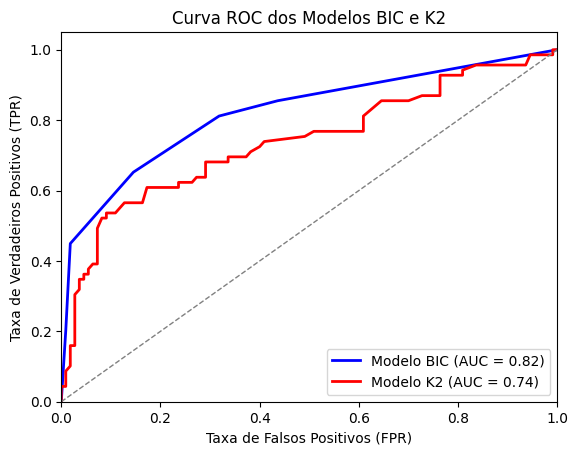

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calcular as curvas ROC
fpr_bic, tpr_bic, _ = roc_curve(test_data['Survived'], probabilities_bic)
roc_auc_bic = auc(fpr_bic, tpr_bic)

fpr_k2, tpr_k2, _ = roc_curve(test_data['Survived'], probabilities_k2)
roc_auc_k2 = auc(fpr_k2, tpr_k2)

# Plotar as curvas
plt.figure()
plt.plot(fpr_bic, tpr_bic, color='blue', lw=2, label=f'Modelo BIC (AUC = {roc_auc_bic:.2f})')
plt.plot(fpr_k2, tpr_k2, color='red', lw=2, label=f'Modelo K2 (AUC = {roc_auc_k2:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC dos Modelos BIC e K2')
plt.legend(loc='lower right')
plt.show()
